In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import time
import pyFAI.detectors,pyFAI.azimuthalIntegrator

In [2]:
def wavelength_(photon_energy):
    ELEMENTARY_CHARGE = 1.602176634E-19 # C
    SPEED_OF_LIGHT = 299792458 # m/s
    PLANCK_CONSTANT = 6.62607015E-34 # Js
    wavelength = PLANCK_CONSTANT*SPEED_OF_LIGHT/(photon_energy*ELEMENTARY_CHARGE)
    return wavelength

In [3]:
# experiment parameters
sample_det_distance = 0.079 
photon_energy = 12000 #eV
wavelength = wavelength_(photon_energy)
pixel_size = 50e-6
det_shape  = [2399,2399]
center = [1200,1200]

# -- file parameters
run = 689943
tag_hit = 484248110
tag_miss = 484248108
file_path = '../../../%s.h5'%run
h5_hit = 'run_%s/detector_2d_assembled_1/tag_%s/detector_data'%(run,tag_hit)
h5_miss = 'run_%s/detector_2d_assembled_1/tag_%s/detector_data'%(run,tag_miss)

# integration parameters
n_qbins = 300

### load h5 and plot single image

to generate the h5 file I run the following commands

MakeTagList -b 3 -r 689943 -det 'MPCCD-8-2-002' -starttag 484248106 -endtag 484248162 -out tag_689943.lst 

DataConvert4 -l tag_689943.lst -dir . -o 689943.h5


In [4]:
# load h5 file
f = h5py.File(file_path, 'r')
#list(f.keys())
#list(f[h5_path].keys())
hit = np.array(f[h5_hit])
miss = np.array(f[h5_miss])

# make mask (note that for pyfai 0 is not masked, others are masked)
mask=hit[:,:]==0

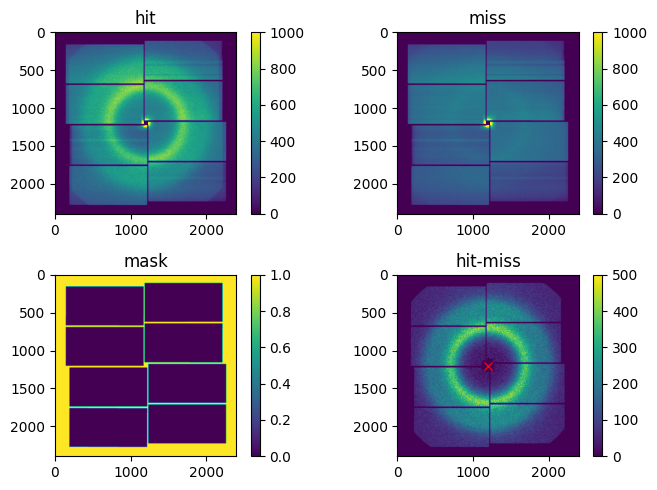

In [5]:
plt.figure(figsize=[7,5])
plt.subplot(2,2,1)
plt.imshow(hit,vmin=0,vmax=1e3)
plt.colorbar()

plt.title('hit')

plt.subplot(2,2,2)
plt.imshow(miss,vmin=0,vmax=1e3)
plt.colorbar()
plt.title('miss')

plt.subplot(2,2,3)
plt.imshow(mask,vmin=0,vmax=1)
plt.colorbar()
plt.title('mask')

plt.subplot(2,2,4)
plt.imshow(hit-miss,vmin=0,vmax=5e2)
plt.colorbar()
plt.title('hit-miss')
plt.plot(center[0],center[1],'x',c='red')
plt.tight_layout()
plt.show()

### azimuthal integration

In [6]:
t0 = time.perf_counter()

det = pyFAI.detectors.Detector(pixel1=pixel_size,pixel2=pixel_size,max_shape=det_shape)
ai  = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=sample_det_distance, detector=det, wavelength=wavelength,poni1=center[0]*pixel_size,poni2=center[1]*pixel_size)
q,I = np.array(ai.integrate1d(hit-miss,n_qbins,mask=mask,unit='q_nm^-1',correctSolidAngle=True,azimuth_range=(-180.,180.),radial_range=(4,40)))

dt = time.perf_counter() - t0
print('time = %.2f s, rate %.2f Hz'%(dt,1/dt))


time = 2.95 s, rate 0.34 Hz


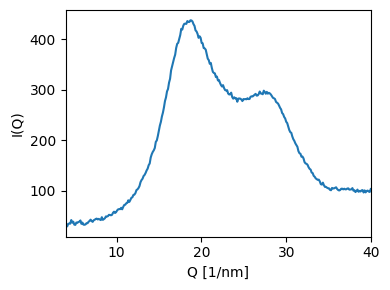

In [7]:
plt.figure(figsize=[4,3])
plt.plot(q,I)
plt.xlabel('Q [1/nm]')
plt.ylabel('I(Q)')
plt.xlim(4,40)
plt.tight_layout()
plt.show()

In [8]:
help(ai.integrate1d)

Help on method integrate1d_ng in module pyFAI.azimuthalIntegrator:

integrate1d_ng(data, npt, filename=None, correctSolidAngle=True, variance=None, error_model=None, radial_range=None, azimuth_range=None, mask=None, dummy=None, delta_dummy=None, polarization_factor=None, dark=None, flat=None, method='csr', unit=q_nm^-1, safe=True, normalization_factor=1.0, metadata=None) method of pyFAI.azimuthalIntegrator.AzimuthalIntegrator instance
    Calculate the azimuthal integration (1d) of a 2D image.
    
    Multi algorithm implementation (tries to be bullet proof), suitable for SAXS, WAXS, ... and much more
    Takes extra care of normalization and performs proper variance propagation.
    
    :param ndarray data: 2D array from the Detector/CCD camera
    :param int npt: number of points in the output pattern
    :param str filename: output filename in 2/3 column ascii format
    :param bool correctSolidAngle: correct for solid angle of each pixel if True 
    :param ndarray variance: arra